In [1]:
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import Dataset, Sampler, DataLoader

In [155]:
a = np.clip(np.round(np.abs(np.random.normal(280, 100, 100000))).astype('uint32') // 20, 5, 20)
b = np.clip(np.round(np.abs(np.random.normal(700, 500, 100000))).astype('uint32') // 20,0, 80)
c = np.round(np.abs(np.random.normal(500, 20, 100000))).astype('uint32') // 50
d = np.arange(100000)

/home/mlsu/miniconda3/envs/PT140/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


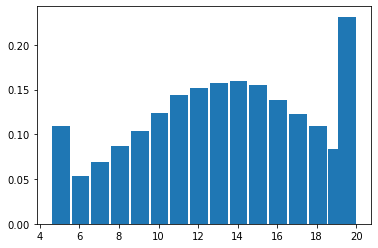

In [64]:
count, bins, ignored = plt.hist(a, 30, normed=True)
plt.bar(bins[:-1], count)
plt.show()

In [183]:
pdf = pd.DataFrame({'data': d, 'a': a, 'b': b, 'c': c})

In [184]:
pdf.head(3)

,data,a,b,c
0,0,20,36,10
1,1,16,41,10
2,2,20,40,10


In [185]:
np.unique(c, return_counts=True)

(array([ 8,  9, 10, 11], dtype=uint32), array([  608, 48572, 50113,   707]))

<BarContainer object of 4 artists>

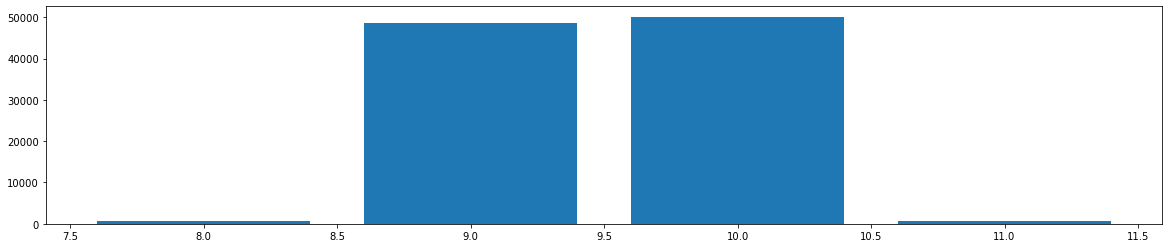

In [182]:
plt.figure(figsize=(20, 4))
plt.bar(*np.unique(c, return_counts=True))

In [204]:
gb = pdf.groupby('a')
len(gb.groups)

16

In [187]:
for g in gb:
    print(g[0])
    break

8


In [125]:
sub_gb = g[1].groupby(['a', 'c'])

In [136]:
for s_g in sub_gb:
    print(s_g[1].index.tolist())
    print(s_g[0], s_g[1].shape[0])
    break

[2198, 6612, 7242, 8215, 8985, 11285, 14849, 17004, 19692, 23627, 26120, 26785, 39344, 41749, 43027, 43533, 52185, 53982, 63045, 71477, 72506, 84590, 87731, 88413, 89031, 89113, 90118, 92380, 93703, 97943, 98995]
(5, 9) 31


In [141]:
s_g[1].loc[s_g[1].index.tolist()[0], 'data']

9999

In [142]:
pdf.loc[2198]

data    2198
a          5
b          0
c          9
Name: 2198, dtype: int64

In [126]:
class Balanced_Sampler(Sampler):
    
    def __init__(self, pdf, count_column, primary_group, secondary_group, size):
        
        self.gb = pdf.groupby(primary_group)
        
        self.size = size
        
        self._g_indices = []
        self._g_weights = []
        
        # equal opportunity at this level
        for g in self.gb:
            indices = []
            weights = []
            sub_gb = g[1].groupby(secondary_group)
            # weighted drawing between sub-groups
            for sub_g in sub_gb:
                indices.append(sub_g[1].index.tolist())
                weights.append(sub_g[1].shape[0])
                
            # post process weights for this group
            weights = np.array(weights)
            weights = weights.sum() / weights
            
            self._g_weights.append(
                list(
                    itertools.chain(*[[w] * len(i) for w, i in zip(weights.tolist(), indices)])
                )
            )
            self._g_indices.append(list(itertools.chain(*indices)))
            
    def __len__(self):
        return self.size
    
    def __iter__(self):
        samples_per_group = np.round(self.size / len(self.gb))
        samples = [random.choices(population=p, weights=w, k=samples_per_group) for p, w in zip(self._g_indices, self._g_weights)]
        return iter([val for tup in zip(*samples) for val in tup])

In [107]:
[val for tup in zip(*[[1,2,3,4,5], ['a', 'b', 'c', 'd', 'e'], ['k','kk','kkk','kkkk','kkkkk']]) for val in tup]

[1, 'a', 'k', 2, 'b', 'kk', 3, 'c', 'kkk', 4, 'd', 'kkkk', 5, 'e', 'kkkkk']

In [4]:
pdf = pd.read_csv('../input/train.csv')

In [5]:
pdf.head(3)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী


In [127]:
test_sampler = Balanced_Sampler(pdf, 'image_id', 'grapheme_root', ['vowel_diacritic', 'consonant_diacritic'], size=150000)

In [128]:
len(test_sampler.gb)

168

In [133]:
150000 / 168

892.8571428571429

In [132]:
150000 - 892 * 168

144

In [110]:
for i, (l0, l1) in enumerate(zip(test_sampler._g_indices, test_sampler._g_weights)):
    if i == 25:
        break

In [135]:
aaa = random.choices(population=l0, weights=l1, k=3000)

In [120]:
np.unique(l1, return_counts=True)

(array([6.59064327, 6.62941176, 6.70833333, 6.83030303, 7.36601307,
        7.41447368, 7.61486486]), array([171, 170, 168, 165, 153, 152, 148]))

In [119]:
np.unique(aaa, return_counts=True)

(array([6.59064327, 6.62941176, 6.70833333, 6.83030303, 7.36601307,
        7.41447368, 7.61486486]), array([433, 403, 468, 442, 396, 420, 438]))

In [ ]:
random.choices(l0, weights=l1

In [124]:
for g in gb:
    print(g[1].shape)

NameError: name 'gb' is not defined

In [257]:
check_index = 4
len(test_sampler._g_indices[check_index]) == len(set(test_sampler._g_indices[check_index]))

True

In [351]:
p = np.array(test_sampler._g_weights[0])
p = p / p.sum()
test = [np.random.choice(test_sampler._g_indices[0], 1000, p=p) for _ in range(5000)]

In [352]:
np.array(test).shape

(5000, 1000)

In [353]:
test_u, test_c = np.unique(np.array(test), return_counts=True)
sum(test_c)

5000000

In [355]:
test_u[np.argmax(test_c)]

2931

In [357]:
np.where(np.array(test_sampler._g_indices[0]) == 2931)

(array([5565]),)

In [358]:
test_sampler._g_weights[0][5565]

5569.0

In [350]:
test_sampler._g_weights[0]

[5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 2784.5,
 2784.5,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 5569.0,
 2784.5,
 2784.5,
 5569.0,
 5569.0,
 2784.5,
 2784.5,
 5569.0,
 5569.0,
 5569.0,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 242.1304347826087,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 142.7948717948718,
 